In [1]:
import math
import cairo
import matplotlib.pyplot as plt

from io import BytesIO
import IPython.display

import queue

In [2]:
NOTE_NAMES = ['I', 'ii', 'II', 'iii', 'III', 'IV', 'v', 'V', 'vi', 'VI', 'vii', 'VII']

In [3]:
def npos(f, f0=440):
	diff_n = math.log(f/f0)/math.log(math.pow(2,1/12))
	x_base = -3 * diff_n
	y_base = 4 * diff_n
	d_base = 7 * diff_n
	k = math.ceil(10000 + (d_base - 12)/24) - 10000
	x = x_base + 12 * k
	y = y_base - 12 * k
	d = y - x
	return (x, y)

In [4]:
npos(523.26, 440)

(2.999119645950053, 0.0011738053999295062)

In [5]:
npos(440*3/2)

(2.9413499740383955, 4.078200034615474)

In [6]:
npos(440*4/3)

(-2.9413499740383635, 7.9217999653844835)

In [7]:
npos(440*2/3)

(-2.9413499740383884, -4.078200034615481)

In [8]:
for semitone, name in enumerate(["A4", "B4b", "B4", "C4", "D4b", "D4", "E4b", "E4", "F4", "F4#", "G4", "A4b", "A5" ]):
    print(f"{name} ({semitone}): {npos(440 * math.pow(2, semitone/12))}")

A4 (0): (0.0, 0.0)
B4b (1): (-3.0, 4.0)
B4 (2): (6.000000000000003, -4.0000000000000036)
C4 (3): (3.000000000000007, -1.0658141036401503e-14)
D4b (4): (1.7763568394002505e-14, 3.999999999999977)
D4 (5): (-2.9999999999999893, 7.999999999999986)
E4b (6): (6.000000000000011, -1.4210854715202004e-14)
E4 (7): (3.000000000000014, 3.9999999999999822)
F4 (8): (1.4210854715202004e-14, 7.999999999999982)
F4# (9): (9.000000000000021, -2.842170943040401e-14)
G4 (10): (6.000000000000021, 3.9999999999999716)
A4b (11): (3.0000000000000284, 7.9999999999999645)
A5 (12): (2.842170943040401e-14, 11.999999999999964)


In [9]:
# https://pythongraphicgames.wordpress.com/2015/03/10/a-primary-color-wheel/

colorRed        = [ "#000000", "#6e0000", "#a00000", "#ff0000", "#ff5050", "#ff8c8c", "#ffc8c8", "#440000" ] # Red
colorRRedGreen  = [ "#000000", "#606000", "#8f9f00", "#b3b300", "#d6d600", "#dbdb30", "#dbdb77", "#3e2700" ] # Khaki
colorRedGreen   = [ "#000000", "#6e6e00", "#a0a000", "#ffff00", "#ffff50", "#ffff8c", "#ffffc8", "#444400" ] # Yellow
colorRedGGreen  = [ "#000000", "#493100", "#692f00", "#a25d00", "#ff8300", "#ffa55a", "#ffb681", "#303030" ] # Orange
colorGreen      = [ "#000000", "#006e00", "#00a000", "#00ff00", "#50ff50", "#8cff8c", "#c8ffc8", "#004400" ] # Green
colorGGreenBlue = [ "#000000", "#003227", "#009358", "#00a141", "#00ff76", "#72ff99", "#acffbf", "#003a1d" ] # Dark green
colorGreenBlue  = [ "#000000", "#006e6e", "#00a0a0", "#00ffff", "#50ffff", "#8cffff", "#c8ffff", "#004444" ] # Cyan
colorGreenBBlue = [ "#000000", "#002c46", "#00639c", "#008cc8", "#00b6ff", "#7bb6ff", "#addfff", "#001a27" ] # Steel Blue
colorBlue       = [ "#000000", "#00006e", "#0000a0", "#0000ff", "#5050ff", "#8c8cff", "#c8c8ff", "#000044" ] # Blue
colorBBlueRed   = [ "#000000", "#470047", "#6c00a2", "#8f00ff", "#b380ff", "#d8b3ff", "#f1deff", "#200031" ] # Purple
colorBlueRed    = [ "#000000", "#6e006e", "#a000a0", "#ff00ff", "#ff50ff", "#ff8cff", "#ffc8ff", "#440044" ] # Crimson
colorBlueRRed   = [ "#000000", "#380023", "#80005a", "#b8007b", "#ff00a1", "#ff64c5", "#ff89ea", "#2e0018" ] # Magenta

COLORS = [
	colorRed,   colorRRedGreen,  colorRedGreen,  colorRedGGreen,
	colorGreen, colorGGreenBlue, colorGreenBlue, colorGreenBBlue,
	colorBlue,  colorBBlueRed,   colorBlueRed,   colorBlueRRed
]

def hue2rgb(p, q, t):
    if (t < 0): t += 1
    if (t > 1): t -= 1

    if (t < 1/6): return p + (q - p) * 6 * t
    if (t < 1/2): return q
    if (t < 2/3): return p + (q - p) * (2/3 - t) * 6

    return p

# Converts an HSL color value to RGB. Conversion formula
# adapted from http://en.wikipedia.org/wiki/HSL_color_space.
# Assumes h, s, and l are contained in the set [0, 1] and
# returns r, g, and b in the set [0, 1].
# See: https://stackoverflow.com/questions/2353211/hsl-to-rgb-color-conversion
def convertHslToRgb(h, s, l):
    if (s == 0):
        r = g = b = l # achromatic
    else:
        if l < 0.5:
            q = l * (1 + s)
        else:
            q = l + s - l * s

        p = 2 * l - q
        r = hue2rgb(p, q, h + 1/3)
        g = hue2rgb(p, q, h)
        b = hue2rgb(p, q, h - 1/3)
    return r, g, b

# Converts an RGB color value to HSL. Conversion formula
# adapted from http://en.wikipedia.org/wiki/HSL_color_space.
# Assumes r, g, and b are contained in the set [0, 1] and
# returns h, s, and l in the set [0, 1].
# See: https://stackoverflow.com/questions/2353211/hsl-to-rgb-color-conversion
def convertRgbToHsl(r, g, b):
    max_rgb_idx, max_rgb = max(enumerate((r, g, b)), key=operator.itemgetter(1))
    min_rgb = min(r, g, b)
    l = (max + min) / 2

    if (max_rgb == min_rgb):
        h = s = 0 # achromatic
    else:
        d = max_rgb - min_rgb
        if l >= 0.5:
            s = d / (2 - (max + min))
        else:
            d / (max_rgb + min_rgb)
        if max_rgb_idx == 0: # r
            h = ((g - b) / d + 0) * 60
        elif max_rgb_idx == 1: # g
            h = ((b - r) / d + 2) * 60
        else: # b
            h = ((r - g) / d + 4) * 60
    return h, s, l

convertHslToRgb(0.5, 0.5, 0.5)

(0.25, 0.7499999999999999, 0.75)

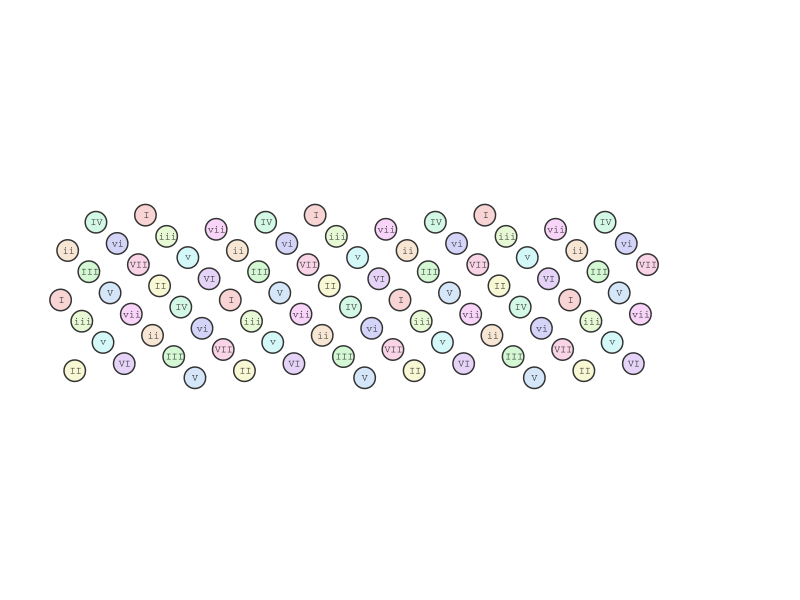

In [10]:
width, height = 800, 600

freq_base = 440.00
midi_base = 69

q = queue.Queue()

ang = -math.pi/4
cang = math.cos(ang)
sang = math.sin(ang)

scale = 10
for semitone, name in enumerate(NOTE_NAMES*7):
    #color = hex2rgb(COLORS[(7*semitone)%12][5])
    color = convertHslToRgb((semitone%12)/12, 0.7, 0.9)
    freq = freq_base / 16 * math.pow(2, semitone/12)
    xpos, ypos = npos(freq, freq_base)
    q.put((name, color, xpos * scale, - ypos * scale))

with BytesIO() as svgio:
    surface = cairo.SVGSurface(svgio, width, height)
    ctx = cairo.Context(surface)

    ctx.save()
    while not q.empty():
        name, color, xpos, ypos = q.get()

        rot_xpos = width/2. + cang * xpos + sang * ypos
        rot_ypos = height/2. + cang * ypos - sang * xpos
        
        ctx.move_to(rot_xpos, rot_ypos)
        ctx.set_line_width(3)
        ctx.set_source_rgb(0.2, 0.2, 0.2)
        ctx.arc(rot_xpos, rot_ypos, 10, 0, 2. * math.pi)
        ctx.stroke_preserve()
        ctx.set_source_rgb(*color)
        ctx.fill()
        
        label = f"{name}"
        ctx.set_source_rgb(0.1, 0.1, 0.1)
        ctx.select_font_face("monospace", cairo.FONT_SLANT_NORMAL, cairo.FONT_WEIGHT_NORMAL)
        ctx.set_font_size(10)
        text_extents = ctx.text_extents(str(label))
        ctx.move_to(rot_xpos - text_extents.width/2., rot_ypos + text_extents.height/2.)
        ctx.show_text(str(label))

    ctx.restore()

    pngio = BytesIO()
    surface.write_to_png(pngio)

    ctx.save()
    surface.finish()
    svg_data = svgio.getvalue()

#print(svg_data)
IPython.display.SVG(data=svg_data)
#IPython.display.Image(data=pngio.getvalue())